In [16]:
%matplotlib inline
# For loading data and colorspace conversion
import cv2

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# For classification/detection
from sklearn import svm
from sklearn import naive_bayes
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble

In [2]:
# Get current dir
import os
cwd = os.getcwd()

In [3]:
# Import aye
import sys
sys.path.append(os.path.join(cwd, '..'))
from aye.preprocessing import resize_image

In [4]:
# Get data dir
data_dir = os.path.join(cwd, '../data')
print('data_dir: ', data_dir)

('data_dir: ', '/home/anuragmakineni/workspace/repo/Galt/detection/notebook/../data')


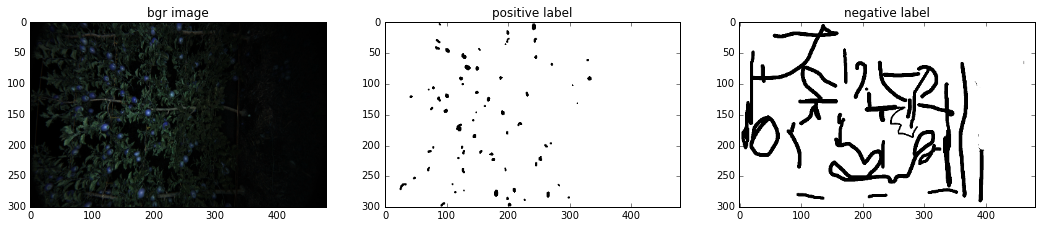

In [8]:
# Read image
im_bgr = cv2.imread(os.path.join(data_dir, 'frame0004.png'))
im_pos = cv2.imread(os.path.join(data_dir, 'frame0004_positive.png'), cv2.IMREAD_GRAYSCALE)
im_neg = cv2.imread(os.path.join(data_dir, 'frame0004_negative.png'), cv2.IMREAD_GRAYSCALE)

# Resize image to quater
k = 0.25
im_pos = resize_image(im_pos, k)
im_neg = resize_image(im_neg, k)
im_bgr = resize_image(im_bgr, k)

# Visualization
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(im_bgr)
ax.set_title('bgr image')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(im_pos, cmap=plt.cm.Greys)
ax.set_title('positive label')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(im_neg, cmap=plt.cm.Greys)
ax.set_title('negative label')

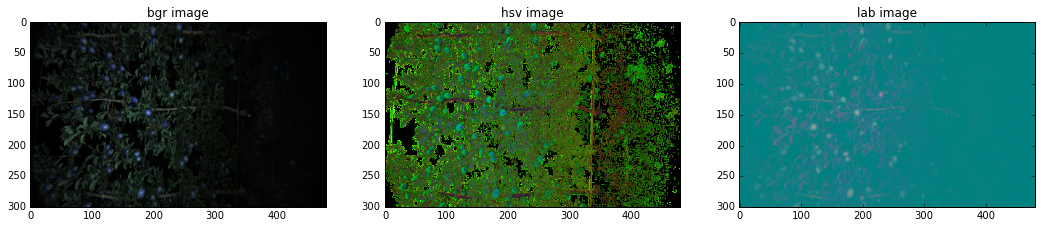

In [9]:
# Covert image to different colorspaces
im_hsv = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2HSV)
im_lab = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2LAB)

# Visualization
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(im_bgr)
ax.set_title('bgr image')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(im_hsv)
ax.set_title('hsv image')
ax = fig.add_subplot(1, 3, 3)

ax.imshow(im_lab)
ax.set_title('lab image')

In [10]:
# Thresholding based on v values in hsv
v = im_hsv[:,:,-1]
v_thresh = 20
mask_v = (v > v_thresh) & (v < 255 - v_thresh)

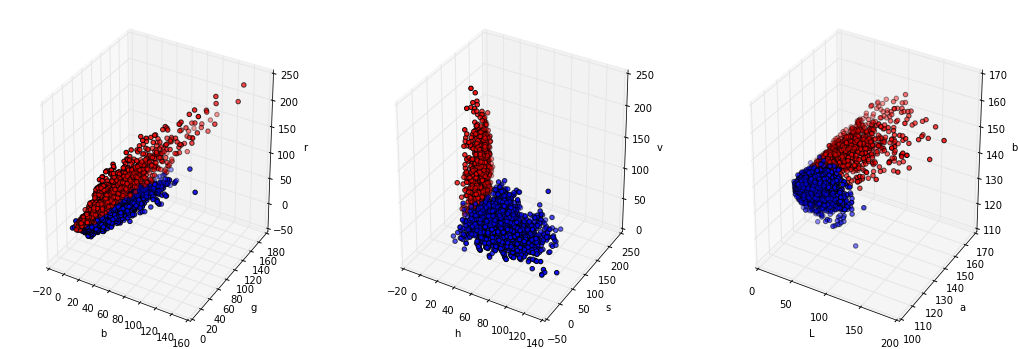

In [11]:
# Extract training and testing data
mask_pos = im_pos > 0
mask_neg = im_neg > 0

mask_pos_v = mask_pos & mask_v
mask_neg_v = mask_neg & mask_v

X_train_pos_bgr = im_bgr[mask_pos_v]
X_train_pos_hsv = im_hsv[mask_pos_v]
X_train_pos_lab = im_lab[mask_pos_v]

X_train_neg_bgr = im_bgr[mask_neg_v]
X_train_neg_hsv = im_hsv[mask_neg_v]
X_train_neg_lab = im_lab[mask_neg_v]

# Visualization
r = 2
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X_train_pos_bgr[::r, 0], X_train_pos_bgr[::r, 1], X_train_pos_bgr[::r, 2], c='r')
ax.scatter(X_train_neg_bgr[::r, 0], X_train_neg_bgr[::r, 1], X_train_neg_bgr[::r, 2], c='b')
ax.set_xlabel('b')
ax.set_ylabel('g')
ax.set_zlabel('r')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(X_train_pos_hsv[::r, 0], X_train_pos_hsv[::r, 1], X_train_pos_hsv[::r, 2], c='r')
ax.scatter(X_train_neg_hsv[::r, 0], X_train_neg_hsv[::r, 1], X_train_neg_hsv[::r, 2], c='b')
ax.set_xlabel('h')
ax.set_ylabel('s')
ax.set_zlabel('v')
ax = fig.add_subplot(133, projection='3d')
ax.scatter(X_train_pos_lab[::r, 0], X_train_pos_lab[::r, 1], X_train_pos_lab[::r, 2], c='r')
ax.scatter(X_train_neg_lab[::r, 0], X_train_neg_lab[::r, 1], X_train_neg_lab[::r, 2], c='b')
ax.set_xlabel('L')
ax.set_ylabel('a')
ax.set_zlabel('b')

In [12]:
# Make a big feature vector
X_train_pos = np.hstack((X_train_pos_bgr, X_train_pos_hsv, X_train_pos_lab))
X_train_neg = np.hstack((X_train_neg_bgr, X_train_neg_hsv, X_train_neg_lab))
# Just to make both labels have similar amount of samples
X_train_neg = X_train_neg[::2]
X_train = np.vstack((X_train_pos, X_train_neg))
X_train = np.array(X_train, float)
print('X_train_pos: ', X_train_pos.shape)
print('X_train_neg: ', X_train_neg.shape)

Y_train_pos = np.ones((np.size(X_train_pos, axis=0),))
Y_train_neg = np.zeros((np.size(X_train_neg, axis=0),))
Y_train = np.hstack((Y_train_pos, Y_train_neg))

print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)

('X_train_pos: ', (2023, 9))
('X_train_neg: ', (3620, 9))
('X_train: ', (5643, 9))
('Y_train: ', (5643,))


In [13]:
# Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [36]:
# Classifiers
clf_svm = svm.SVC()
clf_nb = naive_bayes.GaussianNB()
clf_tree = tree.DecisionTreeClassifier()

# Voting Classifer
eclf = ensemble.VotingClassifier(estimators=[('svc', clf_svm), ('nb', clf_nb), ('dt', clf_tree)], voting='hard')

In [37]:
params = {'svc__kernel':['linear','rbf'], 'svc__C' : [0.1, 1, 10]}

# GridSearch
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid.fit(X_train_scaled, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=VotingClassifier(estimators=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('nb', GaussianNB()), ('dt', DecisionTreeClassifier(cl...it=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))],
         voting='hard', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svc__kernel': ['linear', 'rbf'], 'svc__C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [22]:
print("All Scores for Parameters: ")
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))

All Scores for Parameters: 
0.988 (+/-0.011) for {'svc__kernel': 'linear', 'svc__C': 0.1}
0.988 (+/-0.012) for {'svc__kernel': 'rbf', 'svc__C': 0.1}
0.988 (+/-0.010) for {'svc__kernel': 'linear', 'svc__C': 1}
0.989 (+/-0.010) for {'svc__kernel': 'rbf', 'svc__C': 1}
0.989 (+/-0.010) for {'svc__kernel': 'linear', 'svc__C': 10}
0.989 (+/-0.012) for {'svc__kernel': 'rbf', 'svc__C': 10}


In [24]:
# Load another photo for testing
im_bgr_test = cv2.imread(os.path.join(data_dir, 'frame0001.png'))
im_bgr_test = resize_image(im_bgr_test, k)
im_hsv_test = cv2.cvtColor(im_bgr_test, cv2.COLOR_BGR2HSV)
im_lab_test = cv2.cvtColor(im_bgr_test, cv2.COLOR_BGR2LAB)

In [25]:
# Create a big feature vector for testing
h, w, c = np.shape(im_bgr_test)
X_test_bgr = np.reshape(im_bgr_test, (h * w, -1))
X_test_hsv = np.reshape(im_hsv_test, (h * w, -1))
X_test_lab = np.reshape(im_lab_test, (h * w, -1))
X_test = np.hstack((X_test_bgr, X_test_hsv, X_test_lab))
X_test = np.array(X_test, float)

# Scale test data
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled.shape)

(144000, 9)


In [26]:
# Instead of using all the data, we generate anther mask based on v value
mask_v_test = (im_hsv_test[:,:,-1] > v_thresh) & (im_hsv_test[:,:,-1] < 255 - v_thresh)

mask_v_test = np.reshape(mask_v_test, (-1, ))
X_test_scaled_masked = X_test_scaled[mask_v_test, :]

In [28]:
Y_test_masked = grid.predict(X_test_scaled_masked)

In [29]:
Y_test = grid.predict(X_test_scaled)

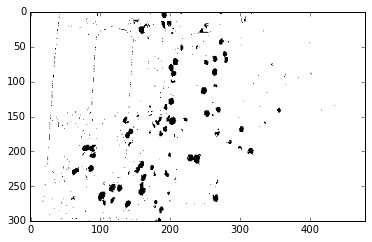

In [30]:
fig = plt.figure(figsize=(6, 6))
bw_test = np.reshape(Y_test, (h , w))
bw_test = bw_test > 0
plt.imshow(bw_test, cmap=plt.cm.Greys)

('Y_test_masked: ', (27143,))
('mask_v_test:', (144000,))


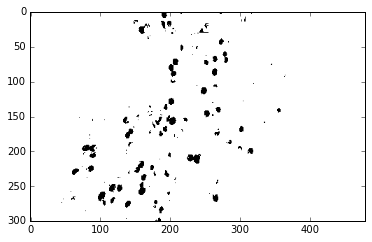

In [31]:
print('Y_test_masked: ', Y_test_masked.shape)
print('mask_v_test:', mask_v_test.shape)

# Unnecessarily complicated
idx_ij = np.where(mask_v_test)
# idx is an array of indices that is masked out by v value
idx = np.array(np.where(mask_v_test)).T
# We only care about those indices that are classified as apple
idx = idx[Y_test_masked > 0]
bw = np.zeros((h * w,))
bw[idx] = 1
bw = np.reshape(bw, (h, w))
plt.imshow(bw, cmap=plt.cm.Greys)

In [32]:
# Unnecessarily complicated
idx_ij = np.where(mask_v_test)
# idx is an array of indices that is masked out by v value
idx = np.array(np.where(mask_v_test)).T
# We only care about those indices that are classified as apple
idx = idx[Y_test_masked_grid > 0]
bw = np.zeros((h * w,))
bw[idx] = 1
bw = np.reshape(bw, (h, w))
plt.imshow(bw, cmap=plt.cm.Greys)

NameError: name 'Y_test_masked_grid' is not defined